In [1]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm.notebook import tqdm
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
from matplotlib.offsetbox import TextArea, HPacker, AnnotationBbox

from isca_tools.cesm import get_pressure
from isca_tools.convection.base import lcl_sigma_bolton_simple
import cartopy.crs as ccrs
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry, temp_kelvin_to_celsius
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory, get_sensitivity_factors
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.decomposition import scaled_k_means_single
from isca_tools.utils.ds_slicing import fold_coarsen
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc, isel_float
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
leg_handlelength = 1.5

## Load data and average over `lon_sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [23]:
%%time
ds = []
with tqdm(total=len(utils.exp_names), position=0, leave=True) as pbar:
    for exp_name in utils.exp_names:
        ds.append(utils.load_ds(exp_name, 95,
                                var_keep=utils.vars_lapse_data + ['FSDS', 'FSNS', 'SOLIN', 'time', 'TS', 'FREQZM', 'LHFLX',
                                                                  'SHFLX', 'CAPE', 'FLNS', 'LHFLX']).load())
        pbar.update(1)
ds = xr.concat(ds, dim=xr.DataArray([utils.get_co2_multiplier(utils.exp_names[i])
                                     for i in range(len(ds))], dims="co2", name='co2'))
# ds = ds.sel(lat=slice(-45, 75))  # ignore antarctica and north pole
ds['albedo'] = 1 - ds.FSNS / ds.FSDS
time_peak_insolation = (ds.time.dt.hour.mean(dim='sample').isel(co2=0) * 0 + (12 - ds.lon / 15) % 24)
ds['time_from_midday'] = (ds.time.dt.hour - time_peak_insolation) % 24
ds['dayofyear'] = ds.time.dt.dayofyear
# ds = ds.drop_vars(['time', 'FSDS', 'FSNS'])
# Only keep land coords
from jobs.theory_lapse.cesm.thesis_figs.scripts.load_ds_tropics import land_frac_thresh

lsm = ds.LANDFRAC.isel(co2=0) > land_frac_thresh
ocean_mask = ds.LANDFRAC.isel(co2=0) == 0

# Chose best rh_mod
ds = utils.sel_best_rh_mod(ds)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1min 1s, sys: 9.73 s, total: 1min 11s
Wall time: 1min 23s


In [4]:
# Duan 2024b analysis
# Rn = ds.SHFLX +  ds.LHFLX
# sens_factor = (ds.SHFLX / Rn).where(ds.SHFLX>0)                  # 1/psi term, only use days where SHFLX positive to avoid blowing up
# sens_factor.mean(dim='sample').where(lsm).isel(co2=0).plot(vmax=1)
# Rn.mean(dim='sample').where(lsm).diff(dim='co2').plot()

# Net energy into surface eqn
# var = (ds.FSNS.mean(dim='sample') - ds.SHFLX.mean(dim='sample')-ds.LHFLX.mean(dim='sample')-ds.FLNS.mean(dim='sample')
#  ).where(lsm)

## Which $p_{FT}$ to choose
Here, 400hPa is better because more *convective* days according to error thresholding, and helps with topography issues i.e. more
regions have at least 100hPa from LCL to FT level.

I plot the difference in number of convective days between 400hPa and 500hPa, and get more (red) especially in tropics for 400hPa.

In [5]:
# get rid of nan - due to different amounts of land at each lat
print('Total number of convective days')
n_days = (~np.isnan(ds.TREFHT.where(lsm))).sum(dim=['lat', 'lon', 'sample']).values
for p_ft in ds.p_ft:
    var1 = utils.get_valid_mask(ds.sel(p_ft=p_ft), aloft_p_size_thresh=0).where(lsm).sum(
        dim=['lat', 'lon', 'sample']).values / n_days * 100
    var2 = utils.get_valid_mask(ds.sel(p_ft=p_ft)).where(lsm).sum(dim=['lat', 'lon', 'sample']).values / n_days * 100
    print(int(p_ft / 100), 'No lcl masking', np.round(var1, 1), 'With lcl masking', np.round(var2, 1))

Total number of convective days
400 No lcl masking [53.6 58.5] With lcl masking [50.2 55.4]
500 No lcl masking [48.2 47.5] With lcl masking [42.3 41.8]


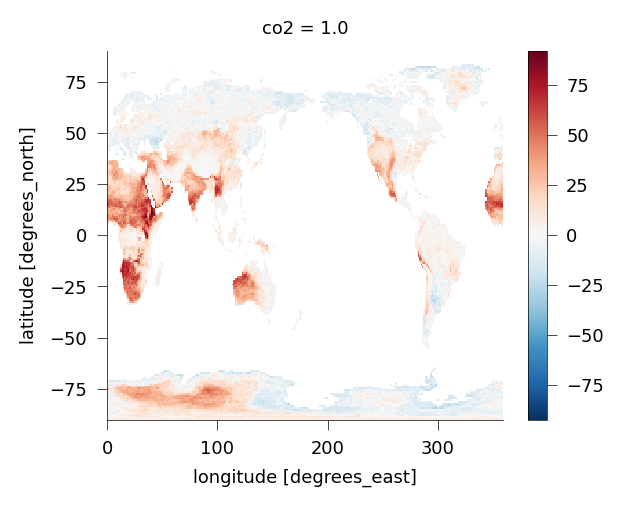

In [6]:
co2_plot_ind = 0

fig, ax = plt.subplots(1, 1)
fig_resize(fig, width['one_col'])
var = [utils.get_valid_mask(ds.sel(p_ft=p_ft)).where(lsm).sum(dim='sample').isel(co2=co2_plot_ind) /
       (~np.isnan(ds.TREFHT)).where(lsm).sum(dim='sample').isel(co2=co2_plot_ind) * 100 for p_ft in ds.p_ft]
(var[0] - var[1]).where(lsm).plot(ax=ax)
update_fontsize(fig)
plt.show()

In [7]:
%%time
p_ft_use = 400 * 100
ds = ds.sel(p_ft=p_ft_use)
ds['p_lnb_approx'] = get_pressure(ds.PS, ds.P0, ds.hyam, ds.hybm).isel(
    lev=ds.lnb1_ind)
ds['lapse_Dz'] = ds.mod_parcel_lapse.isel(layer=0) / 1000 - lapse_dry
ds['lapse_Mz'] = ds.mod_parcel_lapse.isel(layer=1) / 1000
ds['lapse_D'] = R / g * ds.TREFHT * ds['lapse_Dz']
ds['lapse_M'] = R / g * ds.T_ft_env * ds['lapse_Mz']
lat_weights = utils.lat_weights.reindex_like(ds.lat)
temp_surf_lcl_calc = ds.temp_surf_lcl_calc
p_ft = float(ds.p_ft)

# Get rid of variables no longer need. Must remove those without lon, lat, sample in dimensions for fold_coarsen to work
drop_vars = ['hyam', 'hybm', 'lnb1_ind', 'LANDFRAC', 'const_lapse', 'mod_parcel_lapse']
ds = ds.drop_vars(drop_vars)

CPU times: user 267 ms, sys: 424 ms, total: 691 ms
Wall time: 758 ms


## Sanity check for convective definition
Below I compare % of days where convection scheme triggered (b) with % of days classified as convective in our regime.

Also, use to say only consider land as ocean no real convection outside tropics.

In [8]:
# Also avoid regions below freezing
ds['mask_conv'] = utils.get_valid_mask(ds) & (ds.TS > temp_kelvin_to_celsius)
ds['lsm'] = (ds.TREFHT > 0).isel(co2=0) & lsm  # so lsm has sample dimension required for coarsening
ds['lat_weights'] = lat_weights.where((ds.TREFHT > 0).isel(co2=0))

In [188]:
def plot_scatter_mask(mask, ax, s=12, color='k', marker='.', zorder=20, edgecolors='None', linewidths=1.0):
    # Cyclic versions of BOTH data and mask along lon axis=1
    mask_c, lon_c = add_cyclic_point(mask.values.astype(int), coord=mask["lon"].values, axis=1)  # [web:66]
    mask_c = mask_c.astype(bool)

    # Scatter where True (now indices match lon_c)
    iy, ix = np.where(mask_c)

    lon_pts = lon_c[ix]
    lat_pts = mask["lat"].values[iy]

    return ax.scatter(lon_pts, lat_pts, transform=ccrs.PlateCarree(),
                      s=s, marker=marker, facecolors=color, edgecolors=edgecolors, zorder=zorder, linewidths=linewidths)

## Coarsen Grid
Below, I coarsen grid, and then consider regions for which there are atleast 50 valid days at that new larger grid point.
There is still a significant number of regions to do subsequent analysis.

Do that here so in convection point can indicate locations included.

In [26]:
lat_min = -45
lat_max = 75
n_coarse_lat = 4
n_coarse_lon = 4
ds_coarse = fold_coarsen(ds.sel(lat=slice(lat_min, lat_max)), k_lat=n_coarse_lat, k_lon=n_coarse_lon)
ds_coarse['mask_conv'] = ds_coarse['mask_conv'] & ds_coarse['lsm']  # only include land from now on
ds_coarse.attrs['temp_surf_lcl_calc'] = temp_surf_lcl_calc
ds_coarse.attrs['p_ft'] = p_ft
mask_loc = (ds_coarse.mask_conv.sum(dim='sample') > 400).all(dim='co2')  # choose where > 400 days

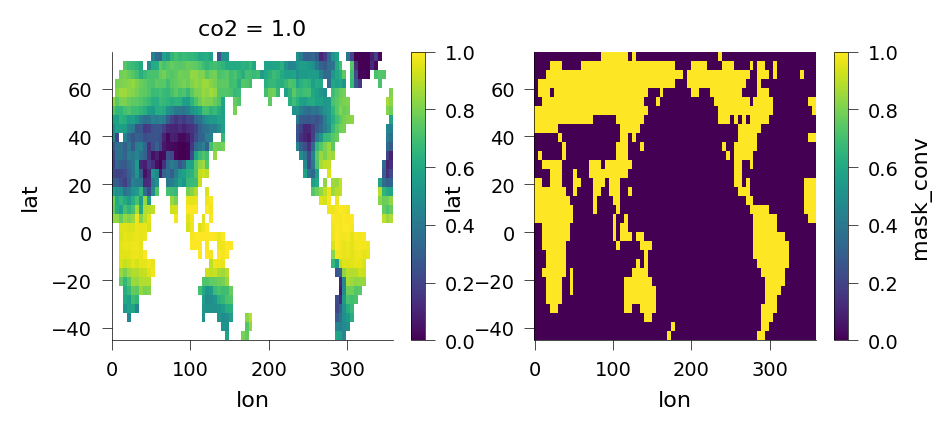

In [54]:
# % of land days convective
fig, ax = plt.subplots(1, 2)
fig_resize(fig, 5)
((ds_coarse.mask_conv).sum(dim='sample') / (ds_coarse.lsm).sum(dim='sample')).isel(co2=0).plot(ax=ax[0])
mask_loc.plot(ax=ax[1])
plt.show()

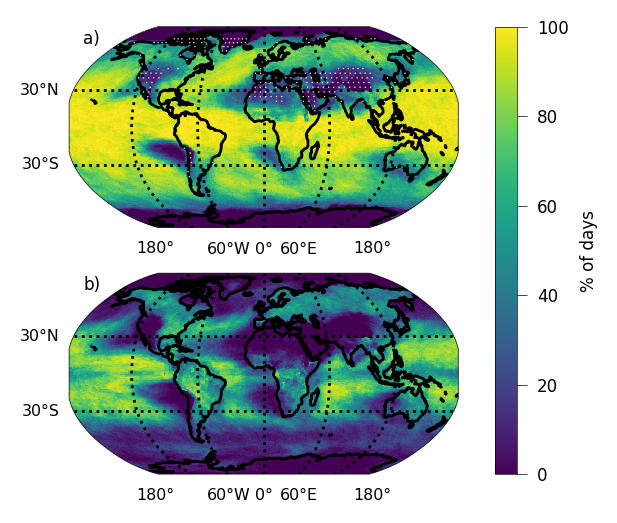

In [61]:
var = [(ds['mask_conv'].sum(dim='sample') / ds.sample.size * 100).isel(co2=0),
       ((ds.FREQZM > 0).sum(dim='sample') / ds.sample.size * 100).isel(co2=0)]

gl_fontsize = 5.74
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
fig_resize(fig, 10, ar=8)
for ax_use in ax:
    gl = utils.initialize_ax_projection(ax_use, lat_min=-90, lat_max=90, grid_lat=[-30, 30], return_gl=True)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
contour_lev = np.linspace(0, 100, 11)
for i in range(len(var)):
    im = utils.plot_contour_projection(ax[i], var[i], mask=None, imshow=True, imshow_kwargs={'vmin': 0, 'vmax': 100})
plt.colorbar(im, ax=ax.ravel(), label='% of days', pad=0.02)

# Add scatter plot showing regions excluded from subsequent analysis
plot_scatter_mask((~mask_loc) & (ds_coarse.lsm.sum(dim='sample')>400), ax[0], color='w', marker='.', s=1)

label_subplots(fig, ax, box_alpha=0, pos_y=-1)
update_fontsize(fig)
plt.show()
# savefig(fig)

In [62]:
# Plots about role of ice
# (ds_coarse.SOLIN).where(ds_coarse.mask_conv).mean(dim='sample').diff(dim='co2').where(mask_loc).plot()
# (ds_coarse.time_from_midday).where(ds_coarse.mask_conv).mean(dim='sample').diff(dim='co2').where(mask_loc).plot()
# (ds_coarse.TS - ds_coarse.TREFHT < 0).where(ds_coarse.mask_conv).sum(dim='sample').diff(dim='co2').where(mask_loc).plot()

In [63]:
# def get_midpoint(var, dim=None):
#     return 0.5 * var.min(dim=dim) + 0.5 * var.max(dim=dim)

## Scaling factor - Zonal Mean
Below I do the scaling factor analysis for the zonal mean.

In [64]:
ds_lat = ds_coarse.where(ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim=['lon', 'sample'])
ds_lat['rh_mod'] = ds.rh_mod[ds_coarse.mod_parcel_rh_mod_ind].where(ds_coarse.mask_conv & mask_loc
                                                                    ).weighted(ds_coarse.lat_weights).mean(
    dim=['lon', 'sample'])
ds_av_global = ds_coarse[['PREFHT', 'rh_REFHT', 'TREFHT', 'lapse_D', 'lapse_M', 'T_ft_env']].where(
    ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim=['lon', 'sample', 'lat'])
ds_av_global['rh_mod'] = ds.rh_mod[ds_coarse.mod_parcel_rh_mod_ind].where(
    ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim=['lon', 'sample', 'lat'])
ds_ref_global = ds_av_global.copy(deep=True)
# weights_use = ds_quant.mask_conv.sum(dim=['co2', 'sample'])
# ds_quant.TREFHT.where(ds_quant.mask_conv).mean(dim=['lon', 'sample']).diff(dim='co2').squeeze().plot()
# ds_quant.TREFHT.where(ds_quant.mask_conv).mean(dim=['sample']).diff(dim='co2').squeeze().weighted(weights_use).mean(dim='lon').plot()


In [65]:
# Set ref values - different from average, except for TREFHT change. Designed so the max positive and min anomaly are the same
# Also ref is forced to be a moist adiabat hence lapse values are zero
norm_by_av = False
# if norm_by_av:
#     ds_ref_global['TREFHT'].values[0] = get_midpoint(ds_lat.TREFHT.isel(co2=0))
#     ds_ref_global['TREFHT'].values[1] = ds_ref_global['TREFHT'].isel(co2=0) + ds_av_global.TREFHT.diff(
#         dim='co2').squeeze()
#     ds_ref_global['rh_REFHT'].values[:] = get_midpoint(ds_lat.rh_REFHT.isel(co2=0))
#     ds_ref_global['PREFHT'].values[:] = get_midpoint(ds_lat.PREFHT.isel(co2=0))
# else:
#     ds_ref_global['rh_REFHT'].values[1] = ds_ref_global['rh_REFHT'].values[0]
#     ds_ref_global['PREFHT'].values[1] = ds_ref_global['PREFHT'].values[0]
ds_ref_global['rh_REFHT'].values[1] = ds_ref_global['rh_REFHT'].values[0]
ds_ref_global['PREFHT'].values[1] = ds_ref_global['PREFHT'].values[0]
ds_ref_global['lapse_D'].values[:] = 0  # so moist adiabat
ds_ref_global['lapse_M'].values[:] = 0
ds_ref_global['rh_mod'].values[:] = 0
# Set reference FT temperature to that following a parcel profile
ds_ref_global['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref_global.rh_REFHT + ds_ref_global.rh_mod,
                                           ds_ref_global.PREFHT,
                                           p_ft, 0, 0, ds_ref_global['TREFHT'],
                                           input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                           kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

In [66]:
# ds_sf_lat = utils.apply_scale_factor_theory(ds_lat, ds_av_global, p_ft, temp_surf_lcl_calc, False, quant_dim='lat', numerical=True)
ds_sf_lat = utils.apply_sf_theory_with_rh_mod(ds_lat, ds_ref_global, p_ft, temp_surf_lcl_calc, numerical=False,
                                              quant_dim='lat')

if norm_by_av:
    # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
    ds_sf_av = utils.apply_sf_theory_with_rh_mod(ds_av_global.expand_dims({"newdim": [0]}), ds_ref_global, p_ft,
                                                 temp_surf_lcl_calc, numerical=False, quant_dim='newdim')
    for key in ds_sf_lat:
        ds_sf_lat[key] = ds_sf_lat[key] - ds_sf_av[key].isel(newdim=0) + 1

ds_sf_lat_num = utils.apply_sf_theory_with_rh_mod(ds_lat, ds_ref_global, p_ft, temp_surf_lcl_calc,
                                                  numerical=True, quant_dim='lat')

if norm_by_av:
    # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
    ds_sf_av_num = utils.apply_sf_theory_with_rh_mod(ds_av_global.expand_dims({"newdim": [0]}), ds_ref_global,
                                                     p_ft, temp_surf_lcl_calc, numerical=False, quant_dim='lat')
    for key in ds_sf_lat_num:
        ds_sf_lat_num[key] = ds_sf_lat_num[key] - ds_sf_av_num[key].isel(newdim=0) + 1

In [67]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_lat_num["nl_sum"] = ds_sf_lat_num['scale_factor_nl'] - ds_sf_lat_num['scale_factor_linear'] + 1

# Set numerical method to show difference to linear theory
for key in ds_sf_lat:
    if 'scale_factor_sum' in key:
        continue
    if 'rh_mod' in key:
        continue
    if 'rh' in key:
        # combine physical and mod linear contributions as done in numerical
        var = ds_sf_lat[key] + ds_sf_lat[key.replace('rh', 'rh_mod')] - 1
    else:
        var = ds_sf_lat[key]
    ds_sf_lat_num[key] = ds_sf_lat_num[key] - var + 1

In [107]:
style_map = utils.style_map_cont
style_map['lapse_D_anom'] = ("C8", ":", utils.labels_cont['lapse_D_anom'])
style_map['nl_temp_surf_anom_lapse_D_anom'] = ('C3', '-', '$\Delta T_s \Delta \eta_D$')
style_map['nl_rh_change_lapse_D_change'] = ('C8', '-', '$\Delta r_s \delta \eta_D$')

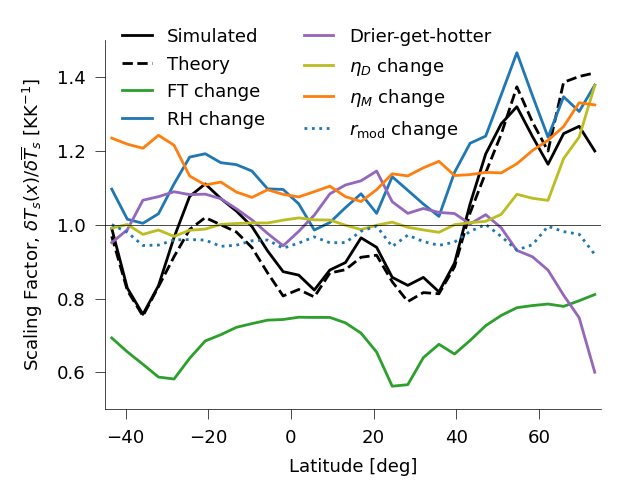

In [104]:
# Ensure when averaging over latitude for each quant, that weight the more convective latitudes more
thresh_sf_individual = 0.04
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False)
fig_resize(fig, width['one_col'])
for key in ['', '_sum']:
    ax.plot(ds_sf_lat.lat, ds_sf_lat[f"scale_factor{key}"],
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label=style_map[f"scale_factor{key}"][2])
# ax.plot(ds_sf_num.quant,
#         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
#         color='k', linestyle='--', label='Linear + nl_r_change')
for key in ds_sf_lat:
    if 'scale_factor' in key:
        continue
    elif 'nl' in key:
        continue
    if np.nanmax(np.abs(ds_sf_lat[key] - 1)) < thresh_sf_individual:
        continue
    ax.plot(ds_sf_lat.lat, ds_sf_lat[key], label=style_map[key][2].replace('Hot', 'Cold'),
            color=style_map[key][0],
            linestyle=style_map[key][1])

update_linewidth(fig)
ax.legend(ncol=2, handlelength=leg_handlelength, bbox_to_anchor=(0, 1.08), loc='upper left')
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel(utils.sf_label)
update_fontsize(fig, 6.5)
ax.set_xlim(lat_min, lat_max)
ax.set_ylim(0.5, 1.5)
# ax[0].legend(ncol=2)
plt.show()
# savefig(fig)

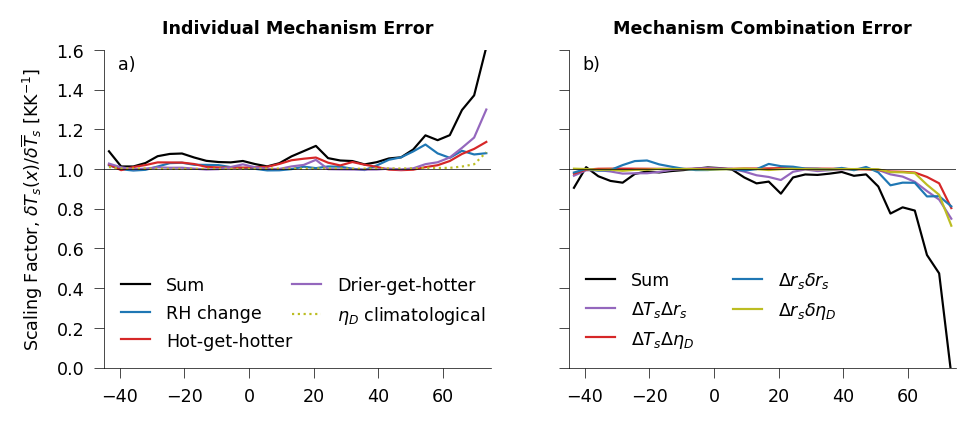

In [123]:
 #%%capture
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
# fig_resize(fig, 10)
ax[0].set_title('Individual Mechanism Error', fontweight='bold')
ax[1].set_title('Mechanism Combination Error', fontweight='bold')
ax[0].plot(ds_sf_lat_num.lat,
           (ds_sf_lat_num['scale_factor_linear'] - ds_sf_lat['scale_factor_sum'] + 1),
           color='k', label='Sum')
ax[1].plot(ds_sf_lat_num.lat, ds_sf_lat_num['nl_sum'],
           color='k', linestyle='-', label='Sum')

# Plot individual mechanism error
for key in ds_sf_lat:
    if 'scale_factor' in key:
        continue
    if 'rh_mod' in key:
        continue
    if np.nanmax(np.abs(ds_sf_lat_num[key] - 1)) < thresh_sf_individual:
        continue
    if np.nanmax(np.abs(ds_sf_lat_num[key] - 1)) > thresh_sf_individual:
        ax[0].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=style_map[key][2],
                   color=style_map[key][0],
                   linestyle=style_map[key][1])

# Plot combination of mechanism error
for key in ds_sf_lat_num:
    if ('nl' not in key) or ('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('residual' in key):
        continue
    if np.nanmax(np.abs(ds_sf_lat_num[key] - 1)) > 0.17:
        # ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=key)
        ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])
# key = 'nl_error_av_change'
# ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=key, color='C6')
# key = 'nl_residual'
# ax[1].plot(ds_sf_lat.lat, ds_sf_lat_num[key], label=key, color='C6')
update_linewidth(fig)

# Reorder ax1 legend
# handles, labels = ax[1].get_legend_handles_labels()
# order = [0, 1, 2, 4, 3, 5]  # desired new order by index
# ax[1].legend([handles[i] for i in order],
#              [labels[i] for i in order], ncol=2, handlelength=leg_handlelength)
ax[0].legend(ncol=2, handlelength=leg_handlelength, columnspacing=0, loc='lower left')
ax[1].legend(ncol=2, handlelength=leg_handlelength, loc='lower left')
label_subplots(fig, ax, pos_y=-2)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
# ax[0].set_xlabel(percentile_label)
# ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel(utils.sf_label)
update_fontsize(fig)
ax[0].set_ylim(0, 1.6)
ax[0].set_xlim(lat_min, lat_max)
plt.show()
# savefig(fig)

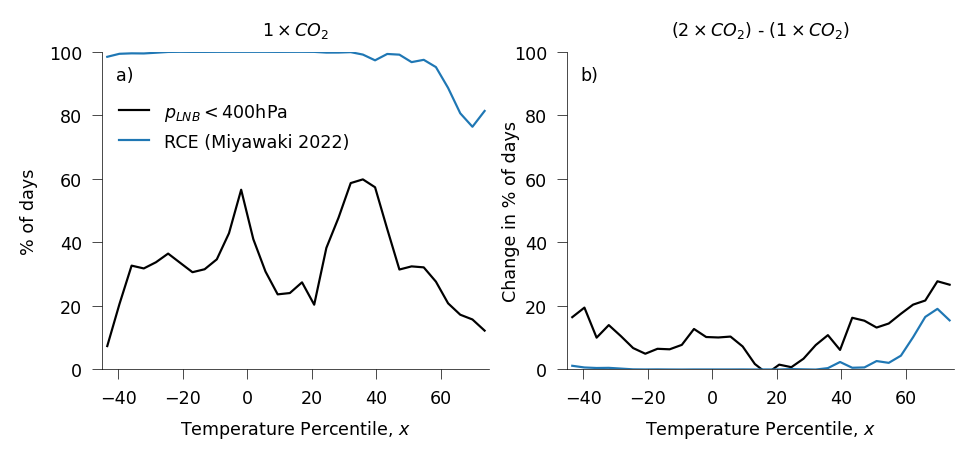

In [134]:
# Probably can just show a spatial version of the right plot
lapse_miy2022_M_thresh = 13  # 13% threshold value for RCE comes from paper
lnb_buoyancy_method = 'lcl'  # think lcl is better - better estimate of height convection can possibly reach
fig, ax = plt.subplots(1, 2, sharex=True)
fig_resize(fig, width['two_col'])
n_sample = (ds_coarse.mask_conv & mask_loc).sum(
    dim=['sample', 'lon'])  # total number of convective days at each location
var = (ds_coarse.p_lnb_approx.where(ds_coarse.mask_conv & mask_loc) < p_ft).sum(dim=['sample', 'lon']) / n_sample * 100
ax[0].plot(ds_lat.lat, var.isel(co2=0), color=f"k", label='$p_{LNB} < ' + f'{p_ft / 100:.0f}$hPa')
ax[1].plot(ds_lat.lat, var.diff(dim='co2').squeeze(), color=f"k")

var = (ds_coarse.lapse_miy2022_M.where(ds_coarse.mask_conv & mask_loc) < lapse_miy2022_M_thresh).sum(
    dim=['sample', 'lon']) / n_sample * 100
ax[0].plot(ds_lat.lat, var.isel(co2=0), color=f"C0",
           label='RCE (Miyawaki 2022)')
ax[1].plot(ds_lat.lat, var.diff(dim='co2').squeeze(), color=f"C0")

update_linewidth(fig)
ax[0].legend(handlelength=leg_handlelength, bbox_to_anchor=(0, 0.9), loc='upper left')
ax[1].legend(handlelength=leg_handlelength)
ax[0].set_xlim(lat_min, lat_max)
for i in range(len(ax)):
    ax[i].set_ylim(0, 100)
    ax[i].set_xlabel(utils.percentile_label)
ax[0].set_ylabel('% of days')
ax[1].set_ylabel('Change in % of days', labelpad=-2)
ax[0].set_xlabel(utils.percentile_label)
ax[0].set_title(utils.co2_labels[0])
ax[1].set_title(f'({utils.co2_labels[1]}) - ({utils.co2_labels[0]})')
label_subplots(fig, ax, box_alpha=0)
update_fontsize(fig)
plt.show()
# savefig(fig)

## Spatial Scaling factor
Below I plot the spatial distribution of the above scaling factor, I plot the theoretical scaling factor and contribution from each mechanism

In [135]:
ds_spatial = ds_coarse.where(ds_coarse.mask_conv & mask_loc).weighted(ds_coarse.lat_weights).mean(dim='sample')
ds_spatial['rh_mod'] = ds.rh_mod[ds_coarse.mod_parcel_rh_mod_ind].where(ds_coarse.mask_conv & mask_loc
                                                                        ).weighted(ds_coarse.lat_weights).mean(
    dim='sample')
norm_by_av_spatial = True           # so change mechanisms normalized about 1

In [139]:
ds_sf_spatial = []
for i in tqdm(range(ds_spatial.lat.size)):
    ds_sf_spatial.append(
        utils.apply_sf_theory_with_rh_mod(ds_spatial.isel(lat=i), ds_ref_global, p_ft, temp_surf_lcl_calc,
                                          quant_dim='lon', numerical=False))
ds_sf_spatial = xr.concat(ds_sf_spatial, dim=ds_spatial.lat)
if norm_by_av_spatial:
    # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
    ds_sf_av_spatial = utils.apply_sf_theory_with_rh_mod(
        ds_av_global.expand_dims({"newdim": [0]}), ds_ref_global, p_ft, temp_surf_lcl_calc,
        quant_dim='newdim', numerical=False).isel(newdim=0, drop=True)
    for key in ds_sf_spatial:
        ds_sf_spatial[key] = ds_sf_spatial[key] - ds_sf_av_spatial[key] + 1

path_output_sf_spatial_num = os.path.join(utils.out_dir, 'ds_sf_spatial_global.nc')
if os.path.exists(path_output_sf_spatial_num):
    ds_sf_spatial_num = xr.load_dataset(path_output_sf_spatial_num)
else:
    # Takes 10 mins for 4 x 4 grid
    ds_sf_spatial_num = []
    for i in tqdm(range(ds_spatial.lat.size)):
        ds_sf_spatial_num.append(
            utils.apply_sf_theory_with_rh_mod(ds_spatial.isel(lat=i), ds_ref_global,
                                              p_ft, temp_surf_lcl_calc, quant_dim='lon', numerical=True))
    ds_sf_spatial_num = xr.concat(ds_sf_spatial_num, dim=ds_spatial.lat)
    # ds_spatial = xr.
    if norm_by_av_spatial:
        # Make sf relative to average day not the ref day - so temp_ft centered on zero etc...
        ds_sf_av_spatial_num = \
            utils.apply_sf_theory_with_rh_mod(ds_av_global.expand_dims({"newdim": [0]}), ds_ref_global,
                                              p_ft, temp_surf_lcl_calc, quant_dim='newdim',
                                              numerical=True).isel(newdim=0, drop=True)
        for key in ds_sf_spatial_num:
            ds_sf_spatial_num[key] = ds_sf_spatial_num[key] - ds_sf_av_spatial_num[key] + 1

  0%|          | 0/32 [00:00<?, ?it/s]

In [140]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_spatial_num["nl_sum"] = ds_sf_spatial_num['scale_factor_nl'] - ds_sf_spatial_num['scale_factor_linear'] + 1
# Set numerical method to show difference to linear theory
for key in ds_sf_spatial:
    if 'scale_factor_sum' in key:
        continue
    if 'rh_mod' in key:
        continue
    if 'rh' in key:
        # combine physical and mod linear contributions as done in numerical
        var = ds_sf_spatial[key] + ds_sf_spatial[key.replace('rh', 'rh_mod')] - 1
    else:
        var = ds_sf_spatial[key]
    ds_sf_spatial_num[key] = ds_sf_spatial_num[key] - var + 1

In [141]:
# Compute scale factor from just hange contribution or just anom contribution
var_names_change = [key for key in ds_sf_spatial if not
(('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('nl' in key) or ('anom' in key))]
var_names_anom = [key for key in ds_sf_spatial if not
(('sum' in key) or ('error' in key) or ('scale_factor' in key) or ('nl' in key) or ('change' in key))]
ds_sf_spatial['scale_factor_change'] = (ds_sf_spatial[var_names_change].to_array(dim="feature") - 1).sum(
    dim='feature') + 1
ds_sf_spatial['scale_factor_anom'] = (ds_sf_spatial[var_names_anom].to_array(dim="feature") - 1).sum(dim='feature') + 1

In [145]:
# Indicate where non drier get hotter mechanisms important & where non-linear important
thresh_mask_nl = 0.2
mask_nl_anom = ds_sf_spatial_num.scale_factor < 0
for key in ds_sf_spatial_num:
    if ('scale_factor' in key) or ('sum' in key) or ('error' in key) or ('change' in key) or ('residual' in key):
        continue
    mask_nl_anom = mask_nl_anom | (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl)
# mask_non_rh_anom = mask_non_rh_anom | (np.abs(ds_sf_spatial.p_surf_anom - 1) > thresh_mask_anom) | \
#                    (np.abs(ds_sf_spatial.temp_surf_anom - 1) > thresh_mask_anom)
mask_nl_anom = mask_nl_anom & mask_loc

# Indicate where non-linear change mechanisms important
mask_nl_change = ds_sf_spatial_num.scale_factor < 0
for key in ds_sf_spatial_num:
    if ('scale_factor' in key) or ('sum' in key) or ('error' in key) or ('change' not in key):
        continue
    mask_nl_change = mask_nl_change | (np.abs(ds_sf_spatial_num[key] - 1) > thresh_mask_nl)
mask_nl_change = mask_loc & mask_nl_change

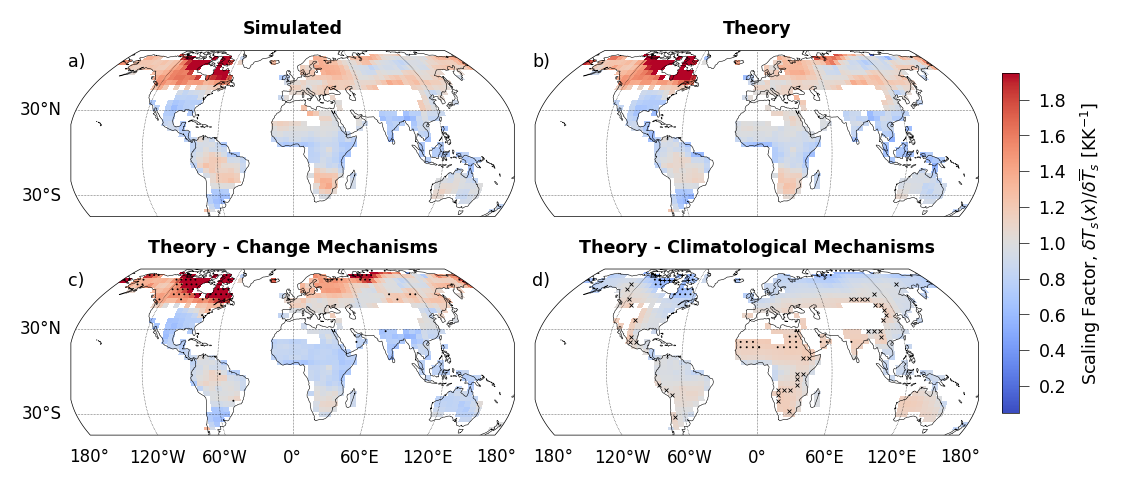

In [276]:
sf_clim = [0.05, 1.95]
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
fig_resize(fig, width['two_col'], ar=2.4)
for i, ax_use in enumerate(ax.flatten()):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.2, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i <= 1:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False
utils.plot_contour_projection(ax[0, 0], ds_sf_spatial.scale_factor.where(mask_loc), cmap='coolwarm',
                              imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})
utils.plot_contour_projection(ax[0, 1], ds_sf_spatial.scale_factor_sum.where(mask_loc),
                              cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})
utils.plot_contour_projection(ax[1, 0], ds_sf_spatial.scale_factor_change.where(mask_loc),
                              cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})
im = utils.plot_contour_projection(ax[1, 1], ds_sf_spatial.scale_factor_anom.where(mask_loc),
                                   cmap='coolwarm', imshow=True, imshow_kwargs={'vmin': sf_clim[0], 'vmax': sf_clim[1]})

# Indicate where nl mechanisms important
plot_scatter_mask(mask_nl_change, ax[1, 0], s=2)
plot_scatter_mask(mask_nl_anom, ax[1, 1], s=2)

# Indicate where non drier-get-hotter mechanism important. I think only these two have contribution of magnitude greater than 0.05.
# No negative contributions have contribution less than -0.05.
plot_scatter_mask(ds_sf_spatial.rh_mod_anom>1.05, ax[1, 1], s=2, marker='+', linewidths=0.3)
plot_scatter_mask(ds_sf_spatial.p_surf_anom>1.05, ax[1, 1], s=2, marker='x', linewidths=0.3)


label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-1, pos_x=-1)
plt.colorbar(im, ax=ax[:, 1].ravel(), label=utils.sf_label, shrink=0.85, ticks=np.arange(0.2, 2, 0.2))
ax[0, 0].set_title('Simulated', fontweight='bold')
ax[0, 1].set_title('Theory', fontweight='bold')
ax[1, 0].set_title('Theory - Change Mechanisms', fontweight='bold')
ax[1, 1].set_title('Theory - Climatological Mechanisms', fontweight='bold')
update_fontsize(fig)
plt.show()
# savefig(fig)

### Individual change mechanisms
Below I plot the individual change mechanisms responsible for the scaling factor. This is not necessary for the climatological mechanisms, as entirely dominated by drier get hotter.

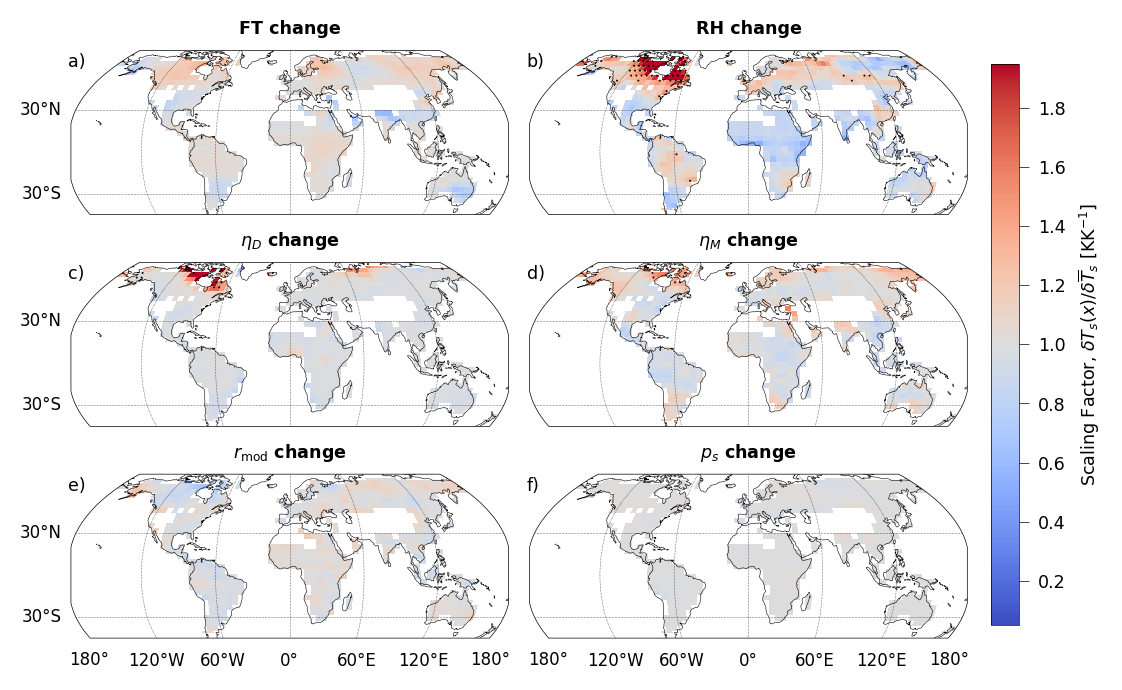

In [277]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0}, sharex=True, sharey=True)
var_order = ['temp_ft', 'rh', 'lapse_D', 'lapse_M', 'rh_mod', 'p_surf']
for i, ax_use in enumerate(ax.flatten()):
    gl = utils.initialize_ax_projection(ax_use, lat_min=lat_min, lat_max=lat_max, grid_lat=[-30, 30], return_gl=True,
                                        coastline_lw=0.2, gridline_lw=0.2)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i <= 3:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False

    ax_use.set_title(utils.labels_cont[f"{var_order[i]}_change"], fontweight='bold')
    im = utils.plot_contour_projection(ax_use, ds_sf_spatial[f"{var_order[i]}_change"].where(mask_loc),
                                       cmap='coolwarm', imshow=True, imshow_kwargs={'vmin':sf_clim[0], 'vmax':sf_clim[1]})
    if 'rh_mod' in var_order[i]:
        continue
    mask_nl_use = np.abs(ds_sf_spatial_num[f"{var_order[i]}_change"] - 1) > thresh_mask_nl
    if mask_nl_anom.any():
        plot_scatter_mask(mask_nl_use, ax_use, s=2)
fig_resize(fig, width['two_col'], ar=2.5)
plt.colorbar(im, ax=ax[:, 1].ravel(), label=utils.sf_label, shrink=0.95, ticks=np.arange(0.2, 2, 0.2))
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-1, pos_x=-1)
update_fontsize(fig)
plt.show()
# savefig(fig)

## Clustering
Here I perform clustering on the change mechanisms, to highlight the regions where mechanisms are extreme. I first convert scaling factor contribution to binary grid based on if higher than a threshold, then I find the unique values of this grid with more than 10 counts to initialize k-means.

Then I do k-means, with the actual values clipped at 0.1, without updating atoms, and removing clusters with less than 20 counts.

The idea is that rather than showing the 4 individual mechanisms, we combine them onto a single figure.
Probably should include the full 4 mechanisms in the appendix though.

In [278]:
def _prepare_X(ds, var_names, clamp_thresh=None):
    X = ds[var_names].to_array(dim="feature")  # (feature, lat, lon)
    Xs = X.stack(sample=("lat", "lon")).transpose("sample", "feature")  # (sample, feature)
    valid = np.isfinite(Xs).all("feature")
    X_valid = Xs.sel(sample=valid)

    if clamp_thresh is not None:
        # This is to get extreme values in binary grid. Anything with larger absolute value than clamp_thresh set to \pm 1
        # Other values set to zero
        X_binary = X_valid.where(np.abs(X_valid) > clamp_thresh)
        X_binary = (X_binary < 0) * (-clamp_thresh) + (X_binary > 0) * clamp_thresh
        X_valid = np.clip(X_valid, -clamp_thresh, clamp_thresh)  # clip X valid between extreme values
    else:
        X_binary = X_valid * 1
    return np.asarray(X_valid.data), X_valid['sample'], np.asarray(X_binary.data)


def remove_duplicate_clusters(centroids, labels):
    # centroids: (cluster, feature)

    # unique centroid rows, and mapping from old cluster -> unique centroid index
    C_unique, inverse = np.unique(centroids, axis=0, return_inverse=True)  # inverse shape (n_clusters,)
    # optional: counts of how many clusters share each unique centroid
    _, counts = np.unique(inverse, return_counts=True)

    has_duplicates = (C_unique.shape[0] < centroids.shape[0])

    # which original clusters are duplicates of an earlier centroid
    dup_mask = np.ones(centroids.shape[0], dtype=bool)
    dup_mask[np.unique(inverse, return_index=True)[1]] = False  # False for first occurrence, True for duplicates
    dup_clusters = np.where(dup_mask)[0]

    labels_new = inverse[labels]  # vectorized remap old->new
    return C_unique, labels_new


def kmeans_no_update_on_xarray(
        ds: xr.Dataset,
        var_names=None,
        init_centroids=None,
        max_iter=200,
        min_points_init=10,
        min_points_final=20,
        clamp_thresh=0.1,
):
    """
    K-means on (lat, lon) grid with constrained centroids:
      var_names_zero = {k: ["feat1","feat2",...], ...}


    init_centroids:
      - None: random init from samples
      - np.ndarray of shape (n_clusters, n_features): used directly
      - xr.DataArray with dims ('cluster','feature') and matching feature names: aligned by feature coord

    Note: This mirrors the idea that k-means can accept an explicit initial center array. [web:34]
    """
    if var_names is None:
        var_names = list(ds.data_vars)

    # (feature, lat, lon)
    Xw, sample_coord, X_binary = _prepare_X(ds, var_names, clamp_thresh)
    n_samples, n_features = Xw.shape

    # --- init centroids ---
    if init_centroids is None:
        #
        vectors, counts = np.unique(X_binary, axis=0, return_counts=True)
        centroids = vectors[counts > min_points_init]
    else:
        if isinstance(init_centroids, xr.DataArray):
            # align by feature name if possible
            if "feature" in init_centroids.dims and "feature" in init_centroids.coords:
                initC = init_centroids.sel(feature=var_names).data
            else:
                initC = init_centroids.data
            centroids = np.asarray(initC, dtype=float).copy()
        else:
            centroids = np.asarray(init_centroids, dtype=float).copy()
    n_clusters = centroids.shape[0]
    if centroids.shape[1] != n_features:
        raise ValueError(
            f"init_centroids has shape {centroids.shape}, expected ({n_clusters},{n_features})"
        )
    prev_labels = None
    for _ in range(max_iter):
        # assign step (squared Euclidean)
        dists = ((Xw[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
        labels = dists.argmin(axis=1)

        # NEW stopping criterion: assignments unchanged
        if prev_labels is not None and np.array_equal(labels, prev_labels):
            break
        prev_labels = labels.copy()

        # update step (means / reseed empties)
        for k in range(n_clusters):
            members = (labels == k)
            if members.sum() < min_points_final:
                centroids[k] = 0
    centroids, labels = remove_duplicate_clusters(centroids, labels)
    n_points = np.unique(labels, return_counts=True)[1]
    # back to (lat, lon)
    labels_1d = xr.DataArray(
        labels,
        coords={"sample": sample_coord},
        dims=("sample",),
        name="cluster",
    )
    labels_map = labels_1d.unstack("sample").reindex(lat=ds["lat"], lon=ds["lon"])

    centroids_da = xr.DataArray(
        centroids,
        coords={"cluster": np.arange(centroids.shape[0]), "feature": var_names},
        dims=("cluster", "feature"),
        name="centroid",
    )

    return labels_map, centroids_da, n_points


In [279]:
var_names_change = [key for key in ds_sf_spatial if not
(('sum' in key) or ('error' in key) or ('scale_factor' in key) or (
        'anom' in key))]

labels, centroids, n_labels = kmeans_no_update_on_xarray(ds_sf_spatial - 1, var_names_change, min_points_final=40)

In [280]:
print(n_labels)

[124 102  61  69  89  96  70  60]


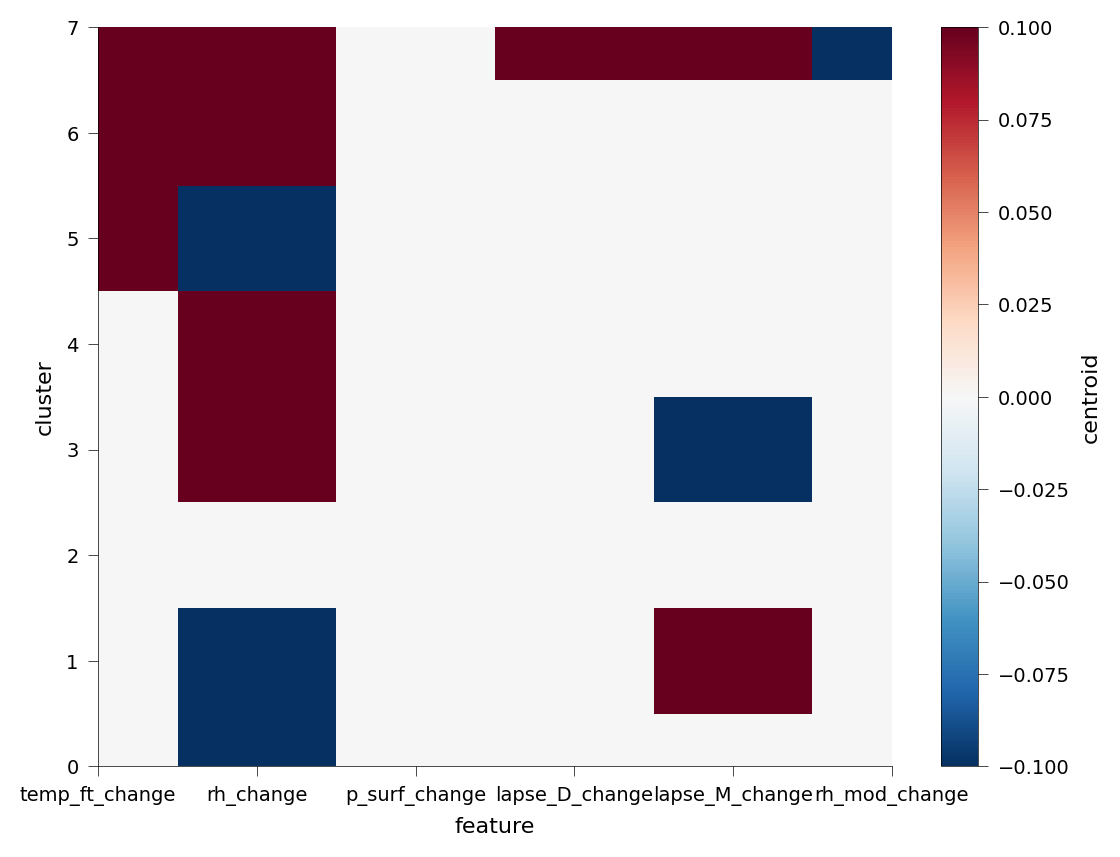

In [284]:
centroids.plot()

In [285]:
# After you made the plot and have the colorbar:
def cbar_multi_color_labels(cbar, label_segments, y_offset=0.3):
    # Function to write colorbar lables in more than one color
    # cbar = m.colorbar
    axc = cbar.ax

    ticks = np.arange(K)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([""] * K)  # hide default tick labels
    cbar.ax.tick_params(which="both", length=0)

    # label_segments[cid] = [("hi ", "red"), ("bye", "blue")]
    for i in range(len(label_segments)):
        segs = label_segments[i]

        # Build multi-colored, single-line label
        children = [
            TextArea(txt, textprops=dict(color=col, va="center"))
            for (txt, col) in segs
        ]
        hbox = HPacker(children=children, align="center", pad=0, sep=0)  # pack inline [web:97]

        # Place it at (x,y) in "y in data, x in axes fraction"
        ab = AnnotationBbox(
            hbox,
            (1.3, i),  # just right of the colorbar
            xycoords=axc.get_yaxis_transform(),  # x in axes, y in data coords
            box_alignment=(0.0, y_offset),
            frameon=False,
            pad=0.0,
            clip_on=False,
        )
        axc.add_artist(ab)
    return None

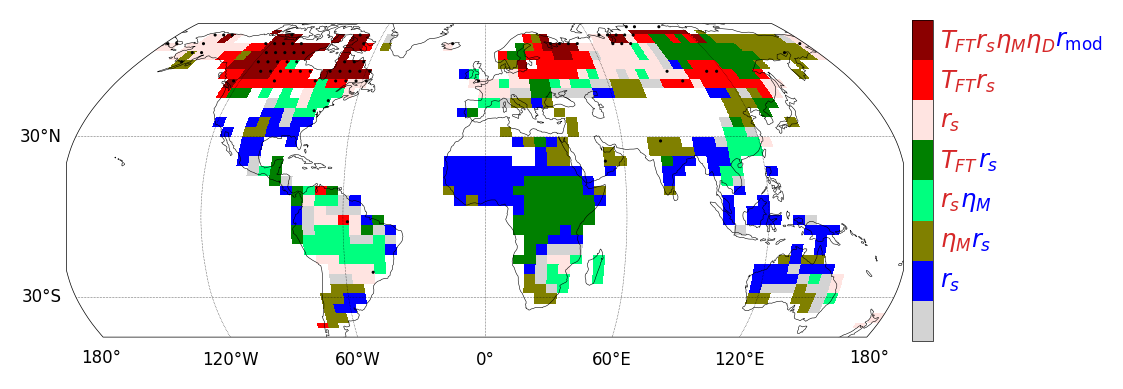

In [294]:
# Inputs you provide
# labels_map: DataArray (lat, lon) with integer labels
# color_dict: {cluster_id: "C0", ...} (any valid Matplotlib color)
# name_dict:  {cluster_id: "Blocked", ...} (your display names)
# desired_order: list/array of cluster_ids in the order you want on the colorbar
# e.g. desired_order = [3, 0, 2, 1]


# desired_order = [2, 1, 0, 3, 4, 5, 6, 7]  # order in legend
# # Colormap in the order you want to show
# colors_cluster = ['navy', 'blue', 'lightgray', 'springgreen', 'olive', 'green', 'mistyrose', 'red']
# label_segments = [[('$r_s \eta_M$', 'blue')],
#                   [('$r_s$', 'blue')],
#                   [],
#                   [('$r_s$', 'C3'), ('$\eta_M$', 'blue')],
#                   [('$T_{FT}$', 'C3'), ('$r_s$', 'blue')],
#                   [('$T_{FT}$', 'C3'), ('$r_s$', 'blue'), ('$\eta_M$', 'C3')],
#                   [('$T_{FT} r_s \eta_M$', 'C3')],
#                   [('$T_{FT} r_s \eta_M \eta_D$', 'C3')]]
desired_order = [2, 0, 1, 3, 5, 4, 6, 7]  # order in legend
# Colormap in the order you want to show
colors_cluster = ['blue', 'olive', 'lightgray', 'springgreen', 'mistyrose', 'green', 'red', 'darkred']
label_segments = [[('$r_s$', 'blue')],
                  [('$\eta_M$', 'C3'), ('$r_s$', 'blue')],
                  [],
                  [('$r_s$', 'C3'), ('$\eta_M$', 'blue')],
                  [('$r_s$', 'C3')],
                  [('$T_{FT}$', 'C3'), ('$r_s$', 'blue')],
                  [('$T_{FT} r_s$', 'C3')],
                  [('$T_{FT} r_s \eta_M \eta_D$', 'C3'), ('$r_{\\text{mod}}$', 'blue')]]

# desired_order: cluster ids in the order you want shown on the colorbar
K = len(desired_order)

# Build mapping: original cluster id -> plotting code 0..K-1
id_to_code = {cid: i for i, cid in enumerate(desired_order)}

# Remap the DataArray (vectorized via NumPy indexing)
max_id = int(labels.max())
lut = np.full(max_id + 1, -1, dtype=int)  # -1 for "unknown" (optional)
for cid, code in id_to_code.items():
    lut[cid] = code

labels_code = xr.apply_ufunc(
    lambda x: lut[x],
    labels.astype(int),
    dask="allowed",
    output_dtypes=[int],
)

# Colormap in desired order
cmap = mcolors.ListedColormap([colors_cluster[cid] for cid in desired_order], name="clusters")
bounds = np.arange(-0.5, K + 0.5, 1)  # monotonic edges
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # discrete mapping [web:41]
gl_fontsize = 6

fig = plt.figure(constrained_layout=True)
ax = fig.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
fig_resize(fig, width['two_col'], ar=3)
gl = utils.initialize_ax_projection(ax, lat_min=lat_min, lat_max=lat_max, coastline_lw=0.2, grid_lat=[-30, 30],
                                    return_gl=True, gridline_lw=0.2)[1]
gl.xlabel_style = {"size": gl_fontsize}
gl.ylabel_style = {"size": gl_fontsize}
im = utils.plot_contour_projection(ax, labels_code.where(mask_loc), imshow=True, cmap=cmap,
                                   imshow_kwargs={'norm': norm})
cbar = plt.colorbar(im, ax=ax, ticks=np.arange(K), pad=0.01, shrink=1, aspect=15)

cbar_multi_color_labels(cbar, [label_segments[i] for i in desired_order])
cbar.set_label('')
# Custom tick labels (cluster names) [web:47]
# cbar = m.colorbar
# cbar.set_ticklabels([name_dict[cid] for cid in desired_order])

# Indicate where NL terms are important - only NL terms involving a change mechanism, anom only nl dealt with in previous plot
plot_scatter_mask(mask_nl, ax, s=5)
# ax.set_title("Clusters")
update_fontsize(fig, base_fontsize=6)
# savefig(fig)
plt.show()

In [103]:
var = np.abs(ds_sf_spatial_num[var_names_anom].to_array(dim="feature") - 1).fillna(0)
axis = var.get_axis_num('feature')
order = var.argsort(axis)  # ascending indices along dim [web:10]
i2 = order.isel({'feature': -2})  # second-from-last index [web:10]

second_largest = var.isel({'feature': i2})

### Exploratory analysis of rh_mod
See than rh_mod is negative in very dry regions, and over tropical oceans.

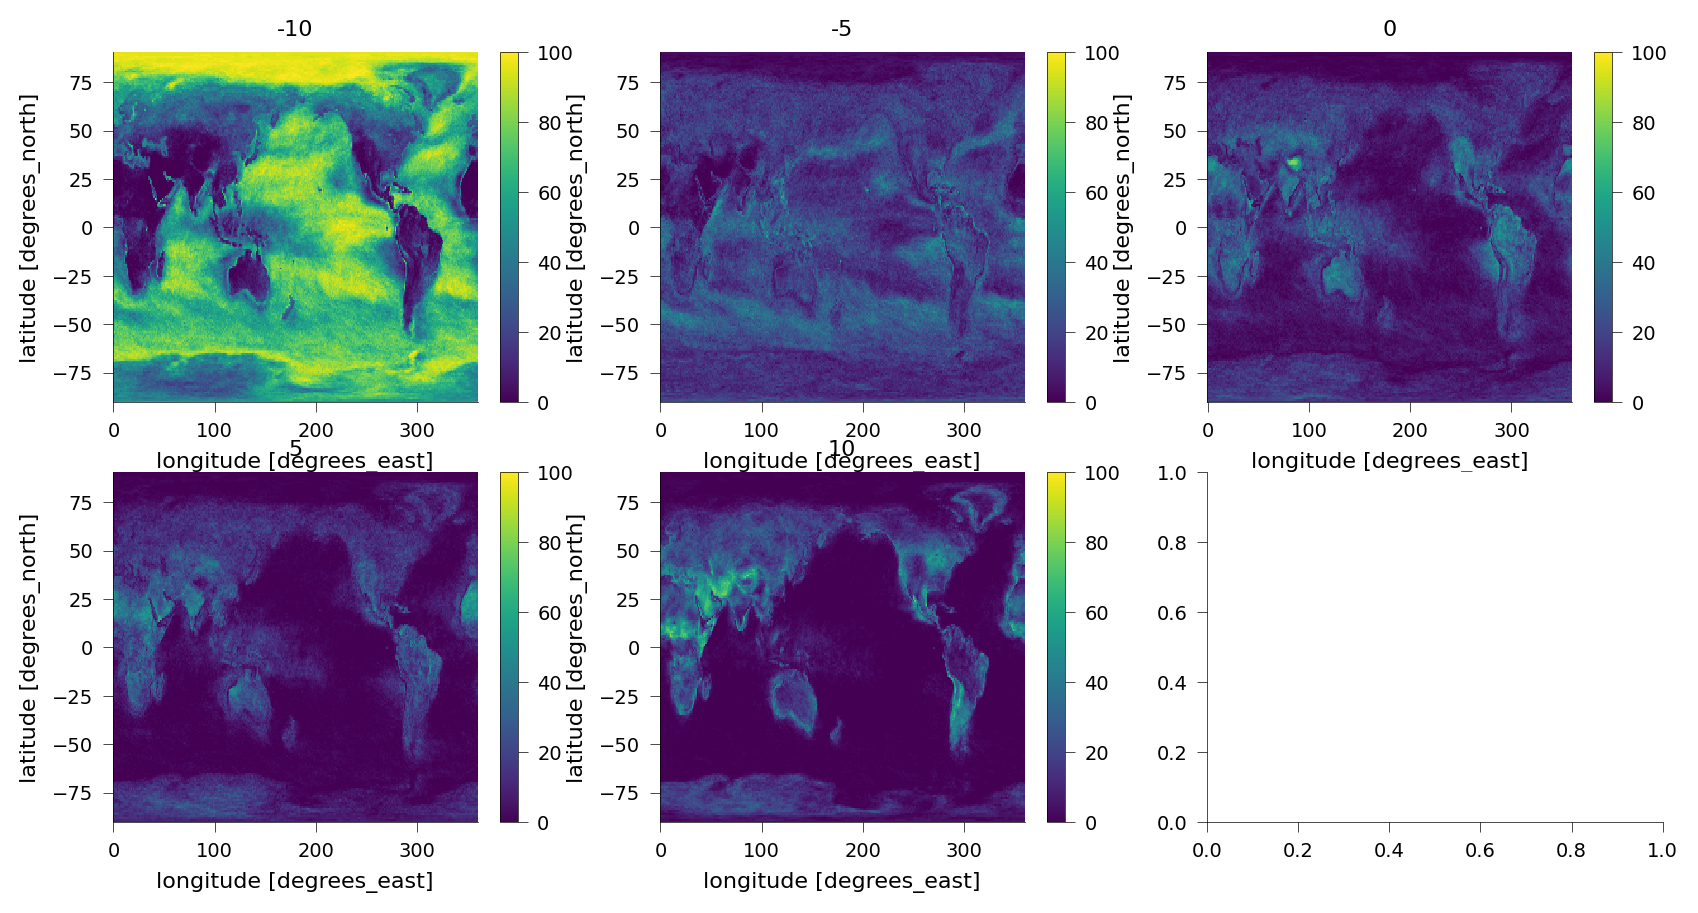

In [295]:
fig, ax = plt.subplots(2, 3)
ax = ax.flatten()
fig_resize(fig, 10)
var = []
for i in range(5):
    var.append((ds.mod_parcel_rh_mod_ind == i).sum(dim='sample') / (ds.TREFHT > 0).sum(dim='sample') * 100)
    var[i].isel(co2=0).plot(vmin=0, vmax=100, ax=ax[i])
    ax[i].set_title(int(ds.rh_mod[i] * 100))
rh_mod_frac = xr.concat(var, dim=ds.rh_mod)

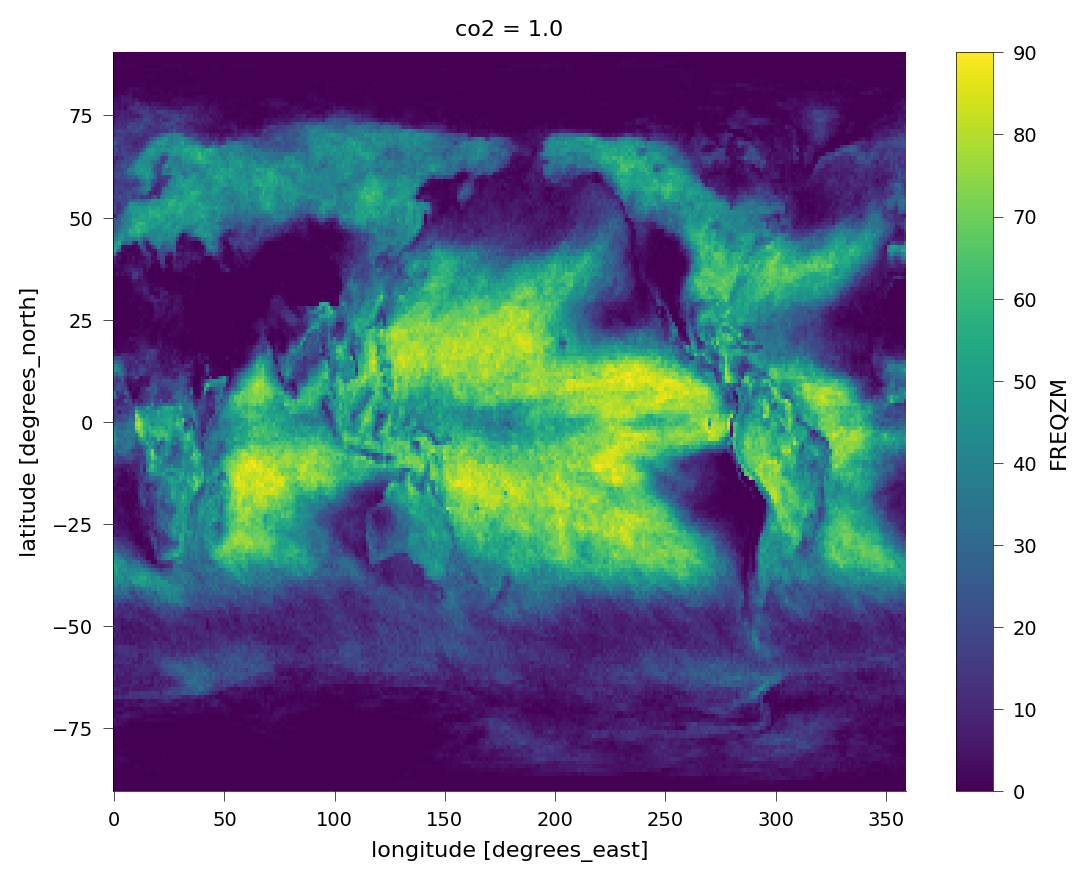

In [311]:
(ds.FREQZM.isel(co2=0)>0).sum(dim='sample').plot(vmax=90)

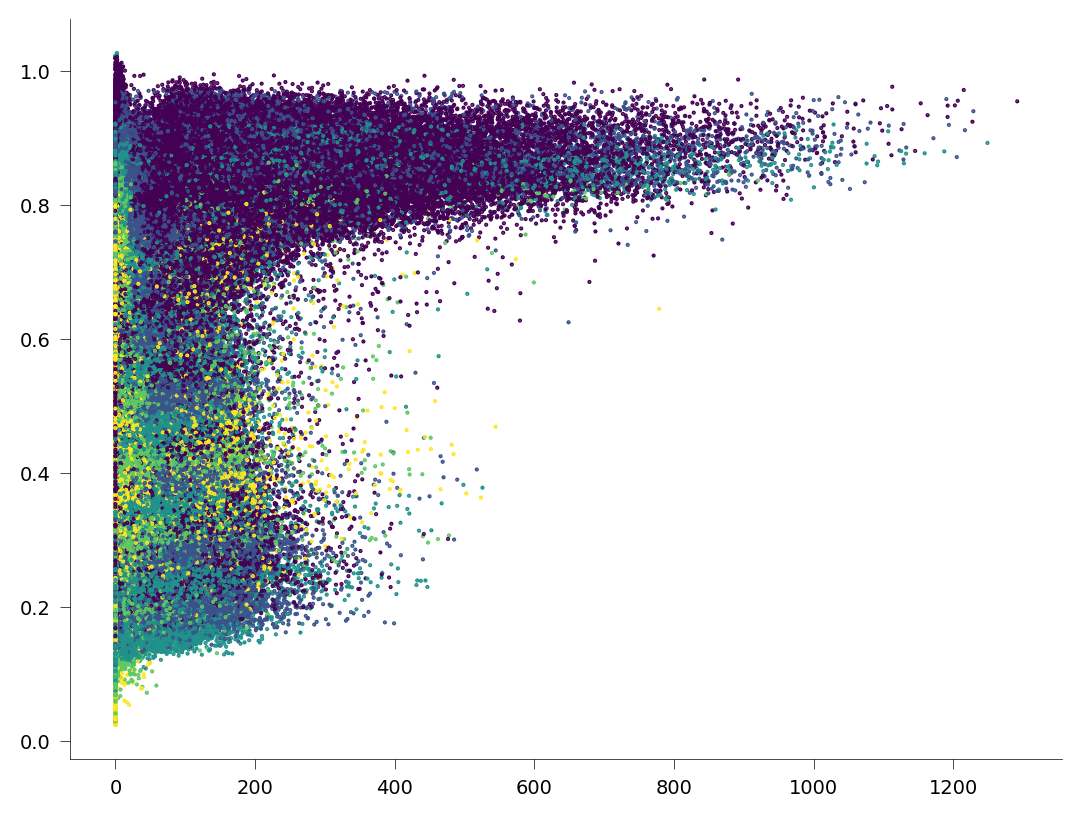

In [328]:
plt.scatter(ds.CAPE.isel(co2=0).sel(lat=slice(-20, 20)),
            ds.rh_REFHT.isel(co2=0).sel(lat=slice(-20, 20)), marker='.', s=1,
            c=ds.mod_parcel_rh_mod_ind.isel(co2=0, p_ft=0).sel(lat=slice(-20, 20)))

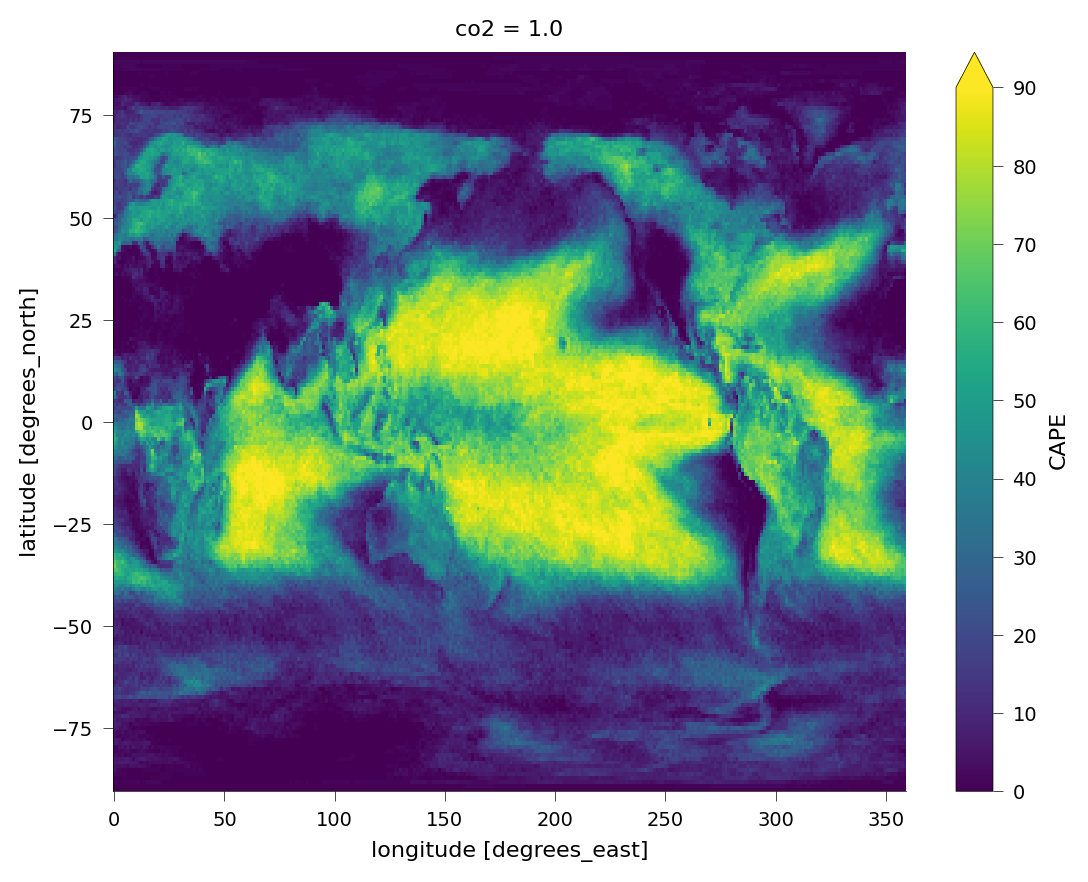

In [315]:
(ds.CAPE.isel(co2=0)>50).sum(dim='sample').plot(vmax=90)

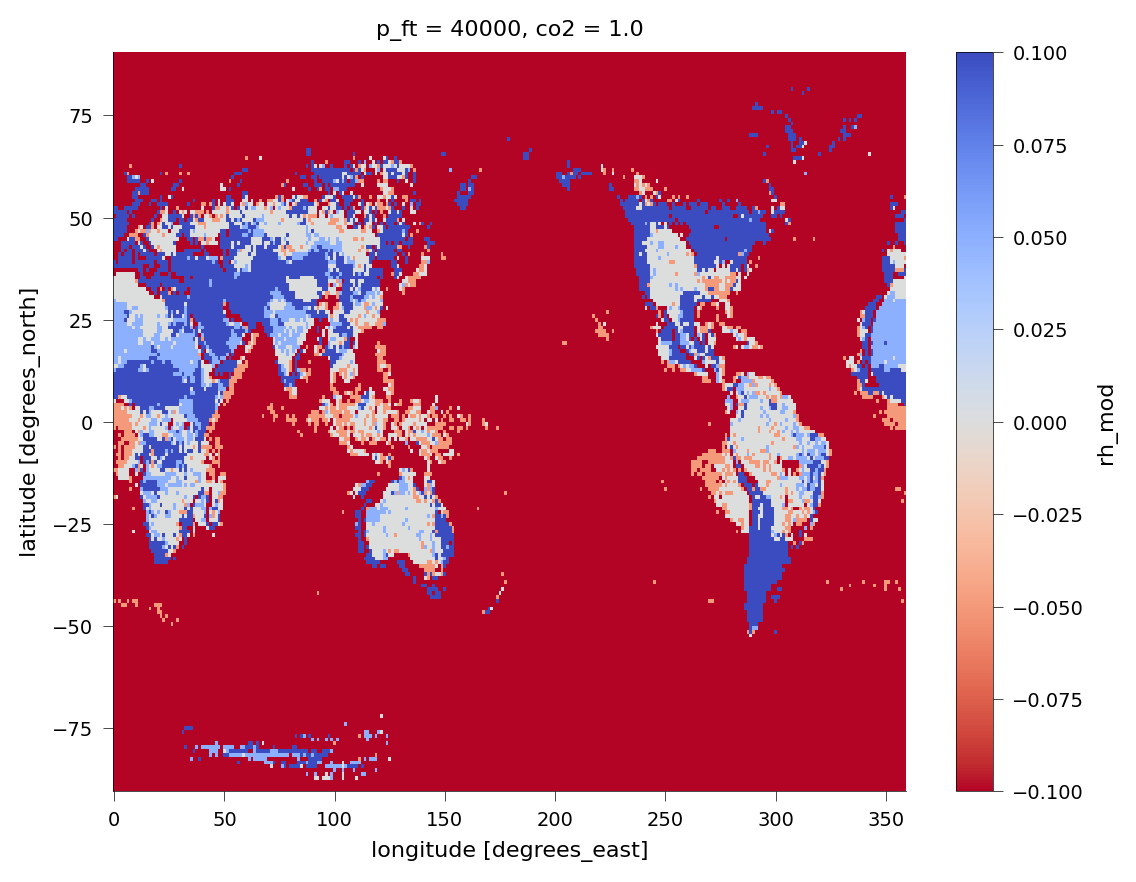

In [296]:
ds.rh_mod[rh_mod_frac.argmax(dim='rh_mod').isel(co2=0)].plot(cmap='coolwarm_r')

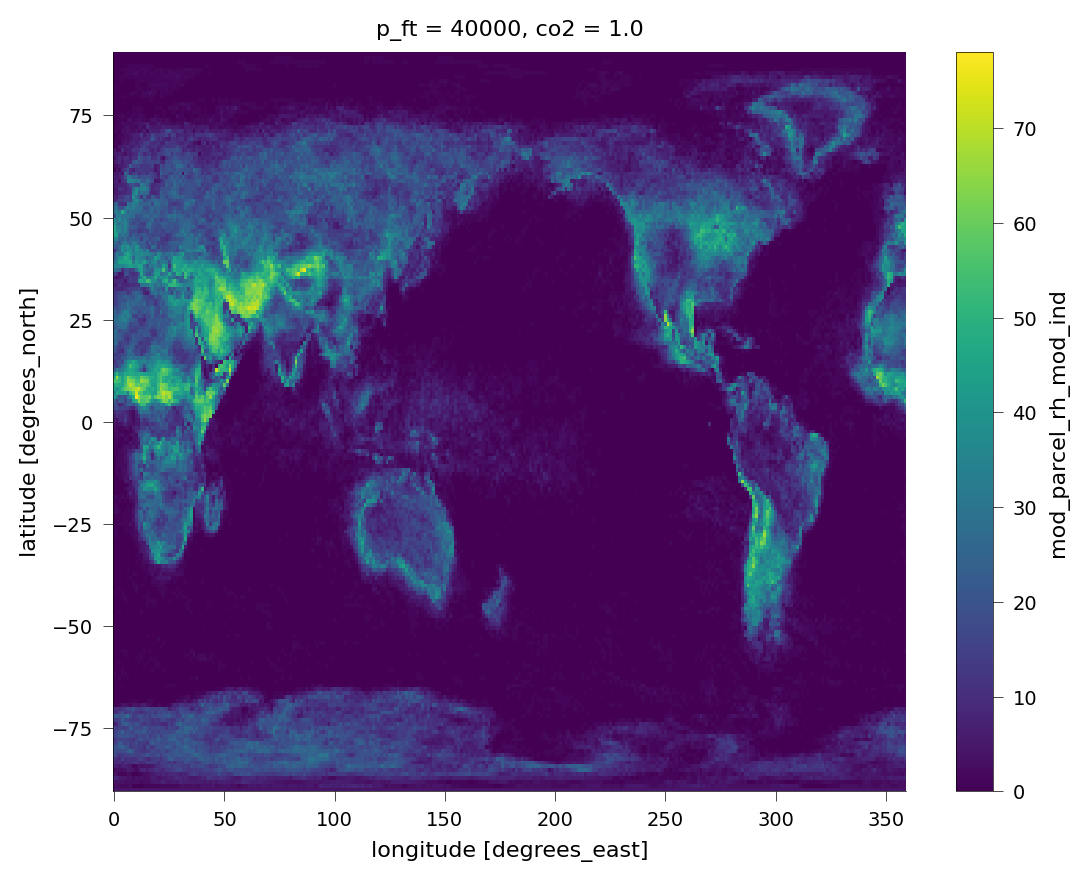

In [299]:
(ds.mod_parcel_rh_mod_ind == 4).sum(dim='sample').isel(co2=0).plot()